This code analyzes the Chl data and creates a model based on the temp and precip data.

Refer to the 3 files of 2.1 for prior information

In [1]:
# !pip install netCDF4
# !pip install xarray

In [2]:
import numpy as np
import pandas as pd
import datetime
import urllib.request
import netCDF4
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# Please refer to 2.1 NJDEP for further detail of the import and processing of data

njdep = pd.read_csv('./NJDEPaircraftData20070101_To_20191001.txt',parse_dates=['date'], index_col='date')
njdep = njdep.drop('id', axis=1)
njdep = njdep.drop('time', axis=1)

njdep = njdep[njdep.lat>0]

delbay = njdep[njdep.lng<-74.8]

delbay = delbay[delbay.lng<-75.0]
delbay = delbay[delbay.lng>-75.1]
delbay = delbay[delbay.lat<39.15]
delbay = delbay[delbay.lat>39.05]

delbay_avg = delbay.resample('D').mean()
delbay_avg = delbay_avg.dropna(axis=0,how="any")
delbay_avg = delbay_avg.reset_index()

In [4]:
# Please refer to 2.1 Aqua for further detail of the import and processing of data

ds = xr.open_dataset('Aqua1DayAggregate.nc')
aqua = ds.to_dataframe()
aqua = aqua.reset_index()
aqua = aqua.set_index('time')
aqua = aqua.resample('D').mean()
aqua = aqua.reset_index()
aqua = aqua.dropna(axis=0,how="any")
# aqua.chl_oc3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


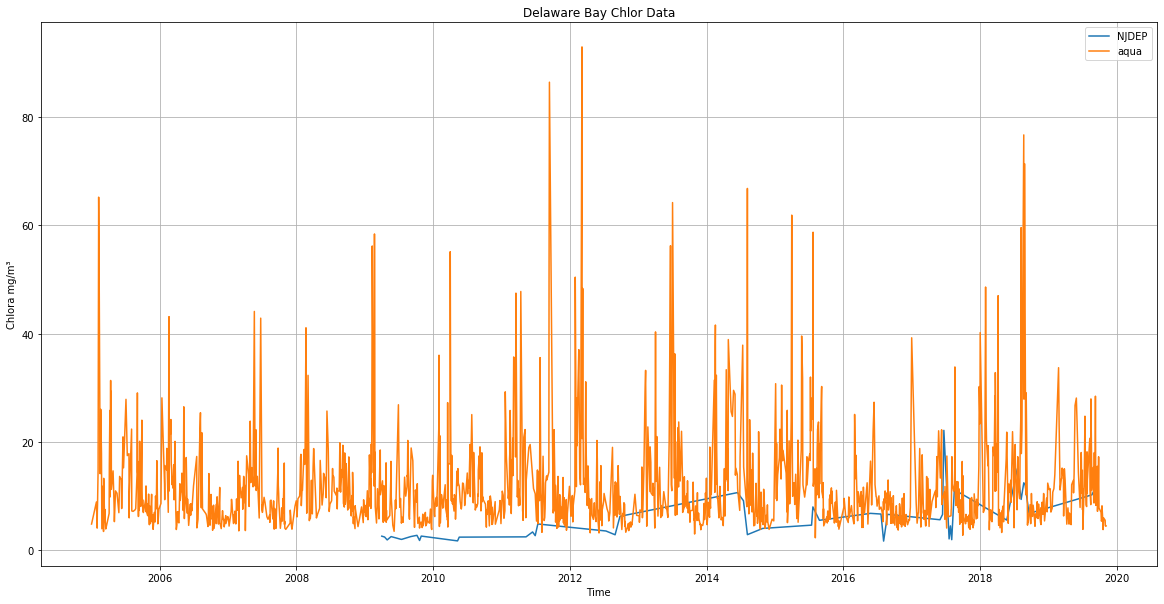

In [5]:
# This is one plot of both Aqua and NJDEP data sets. The NJDEP data is very sparse and thus is not used in analysis.

fig1 = plt.figure(figsize=(20, 10))
ax1 = fig1.add_subplot(111)
ax1.plot(delbay_avg['date'], delbay_avg['chlora'], label='NJDEP')
ax1.plot(aqua['time'], aqua['chl_oc3'], label='aqua')
plt.xlabel('Time')
plt.ylabel('Chlora mg/m³')
plt.title('Delaware Bay Chlor Data')
ax1.legend()
ax1.grid()

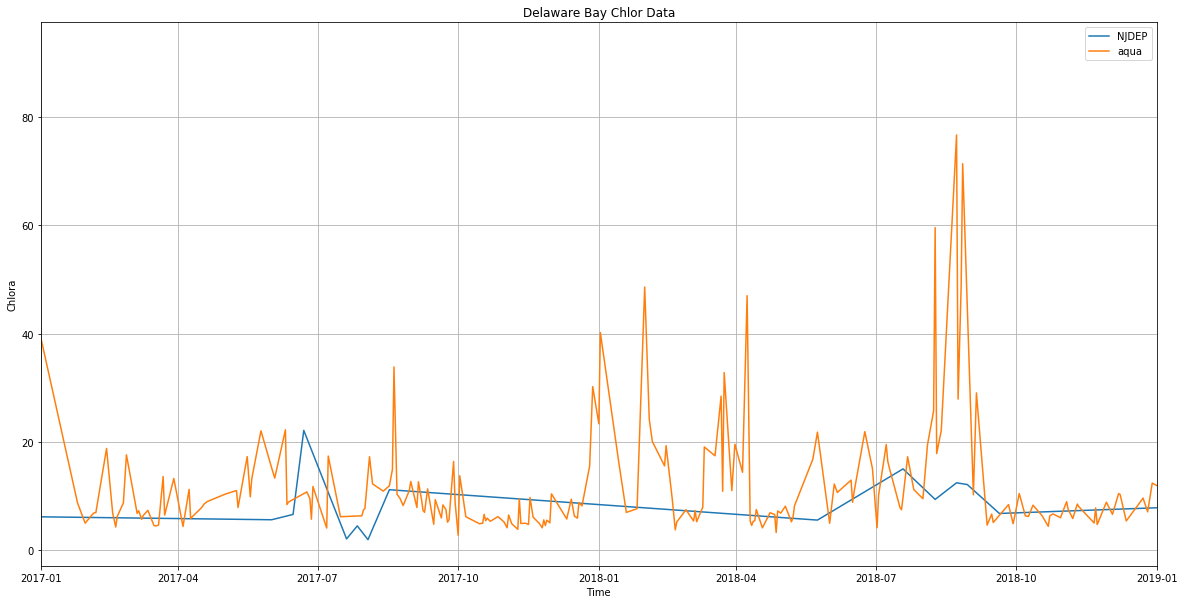

In [6]:
# A smaller section of the previous plot in greater detail

fig1 = plt.figure(figsize=(20, 10))
ax1 = fig1.add_subplot(111)
ax1.plot(delbay_avg['date'], delbay_avg['chlora'], label='NJDEP')
ax1.plot(aqua['time'], aqua['chl_oc3'], label='aqua')
plt.xlabel('Time')
plt.ylabel('Chlora')
plt.title('Delaware Bay Chlor Data')
ax1.legend()
ax1.set_xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2019-01-01'))
ax1.grid()

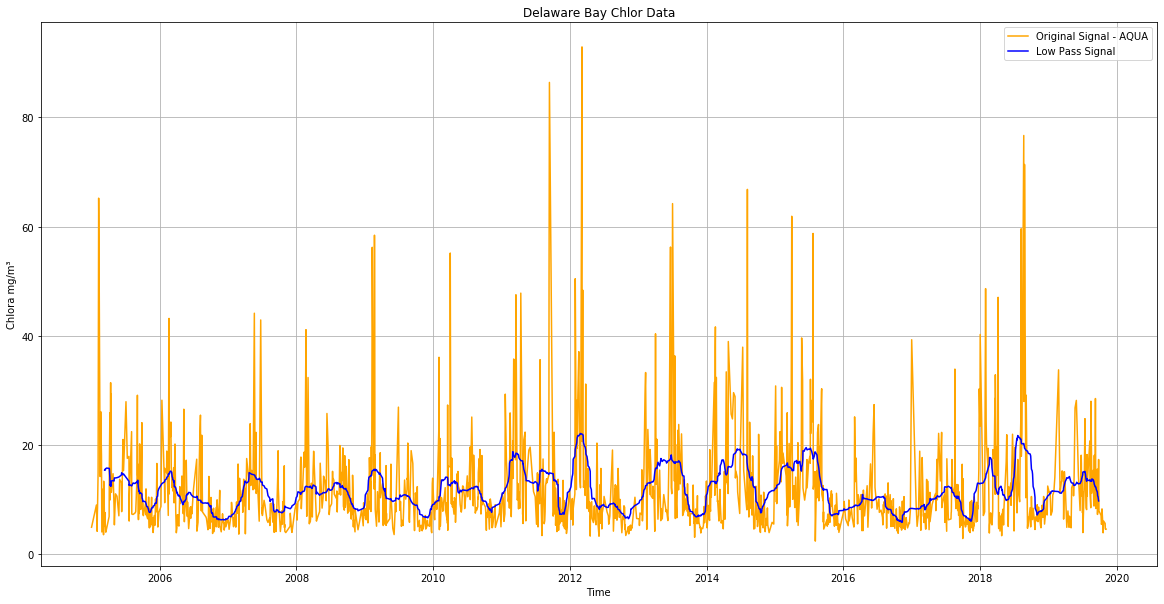

In [7]:
# Create Low Pass Filter 

origSignalChl = aqua.chl_oc3

windowSize = 30 #30 day window seems appropriate given the time scale of the data (years)

lowPassChl = origSignalChl.rolling(windowSize, center=True).mean()

# A large plot of signal vs low pass filter, shown again in the following cell

fig1 = plt.figure(figsize=(20, 10)) #figsize=(50, 20)
ax1 = fig1.add_subplot(111)
ax1.plot(aqua['time'], aqua['chl_oc3'], label='Original Signal - AQUA', c='orange')
ax1.plot(aqua['time'], lowPassChl, label='Low Pass Signal', c='b')

plt.xlabel('Time')
plt.ylabel('Chlora mg/m³')
plt.title('Delaware Bay Chlor Data')
ax1.legend()
ax1.grid()

Text(0.5, 1.0, 'Delaware Bay Chlor - Low Pass Signal')

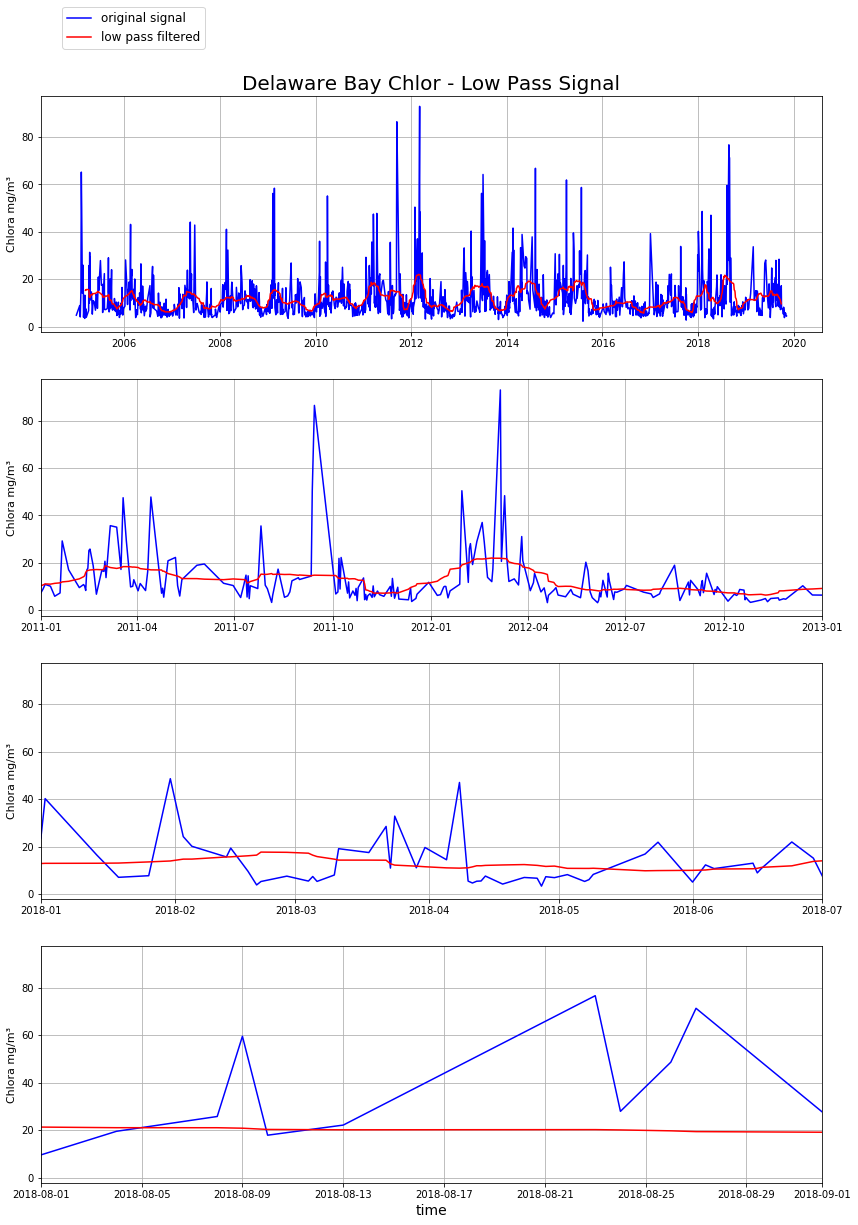

In [8]:
# Plot Low Pass Filter (Rolling Mean) vs Signal

t0 = aqua.time

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,20))

ax[0].plot(t0,origSignalChl,c='b')
ax[0].plot(t0,lowPassChl,c='r')

ax[1].plot(t0,origSignalChl,c='b')
ax[1].plot(t0,lowPassChl,c='r')
ax[1].set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2013-01-01'))

ax[2].plot(t0,origSignalChl,c='b')
ax[2].plot(t0,lowPassChl,c='r')
ax[2].set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-07-01'))

ax[3].plot(t0,origSignalChl,c='b')
ax[3].plot(t0,lowPassChl,c='r')
ax[3].set_xlim(pd.Timestamp('2018-08-01'), pd.Timestamp('2018-09-01'))


ax[0].legend(['original signal','low pass filtered'], fontsize=12,
              loc='upper left',bbox_to_anchor=(0.02,1.4))
for i in range(len(ax)): ax[i].set_ylabel('Chlora mg/m³', fontsize=11)
for i in range(len(ax)): ax[i].grid()

ax[3].set_xlabel('time', fontsize=14);
ax[0].set_title('Delaware Bay Chlor - Low Pass Signal',fontsize=20)

Text(0.5, 0, 'time')

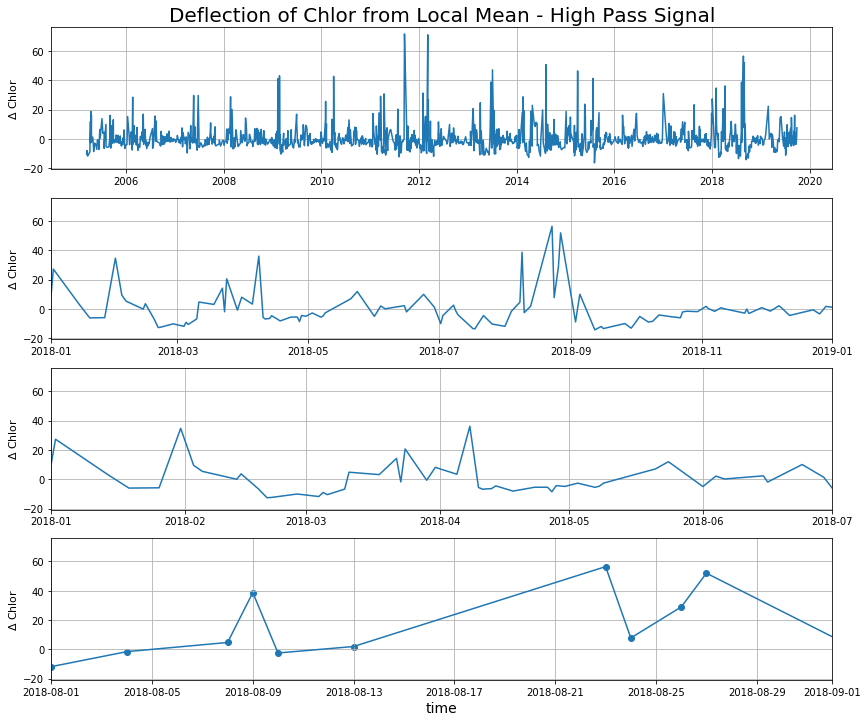

In [9]:
# Plot High Pass Filter (Original Signal - Low Pass / Rolling Mean)

highPassChl = origSignalChl - lowPassChl

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,12))
ax[0].plot(t0,highPassChl)

ax[1].plot(t0,highPassChl)
ax[1].set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2019-01-01'))

ax[2].plot(t0,highPassChl)
ax[2].set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-07-01'))

ax[3].scatter(t0,highPassChl)
ax[3].plot(t0,highPassChl)
ax[3].set_xlim(pd.Timestamp('2018-08-01'), pd.Timestamp('2018-09-01'))

ax[0].set_title('Deflection of Chlor from Local Mean - High Pass Signal',fontsize=20)
for i in range(len(ax)): ax[i].set_ylabel('$\Delta$ Chlor', fontsize=11)
for i in range(len(ax)): ax[i].grid()

ax[3].set_xlabel('time', fontsize=14)

Text(0.5, 1.0, 'Autocorrelation Plot of Low Pass Filtered Signal')

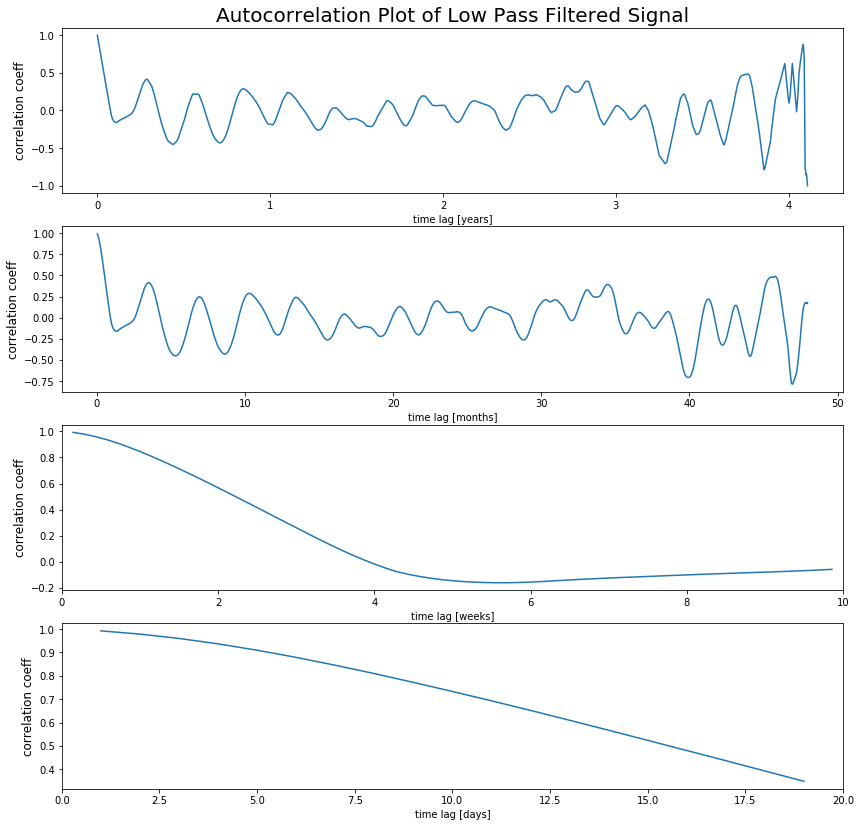

In [10]:
lowPass = aqua.copy()
lowPass.chl_oc3 = lowPassChl
lowPass.time = lowPass.time - lowPass.time.iloc[0]
timeLags = lowPass.time.dt.days
# timeLags/365
# timeLags

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,14))

autoCorr = [lowPassChl.autocorr(lag=dt) for dt in timeLags]
ax[0].plot(timeLags/365, autoCorr); 
ax[0].set_xlabel('time lag [years]'); ax[0].set_ylabel('correlation coeff', fontsize=12);
# ax[0].set_xlim(0, 10)

timeLags = np.arange(1,48*30) # 48 months
autoCorr = [lowPassChl.autocorr(lag=dt) for dt in timeLags]
ax[1].plot(1/30*timeLags, autoCorr); 
ax[1].set_xlabel('time lag [months]'); ax[1].set_ylabel('correlation coeff', fontsize=12);
# ax[1].set_xlim(0, 120)

timeLags = np.arange(1,10*7) # 10 weeks
autoCorr = [lowPassChl.autocorr(lag=dt) for dt in timeLags]
ax[2].plot(1/7*timeLags, autoCorr);
ax[2].set_xlabel('time lag [weeks]'); ax[2].set_ylabel('correlation coeff', fontsize=12);
ax[2].set_xlim(0, 10)

timeLags = np.arange(1,20) # 20 days
autoCorr = [lowPassChl.autocorr(lag=dt) for dt in timeLags]
ax[3].plot(timeLags, autoCorr);
ax[3].set_xlabel('time lag [days]'); ax[3].set_ylabel('correlation coeff', fontsize=12);
ax[3].set_xlim(0, 20)

ax[0].set_title('Autocorrelation Plot of Low Pass Filtered Signal', fontsize=20)


There is an error with the autocorrelation plots above and below. The data spans 15 years, and there are 15 distinct periods in the signal above. However, the time associated with this data is not daily (every conesecutive day) - there are several days between data points, and a total of ~1500 values in the list of days (1500/365=4.1 years). Once the autocorr calculation is run, the autocorr data set is a list with only ~400 values that are not "nan". These values are then paired with the time data - the first ~400 values in the time data only span about 48 months. This is why the charts show the data spanning ~4.0 years or ~48 months instead of 15 years. 

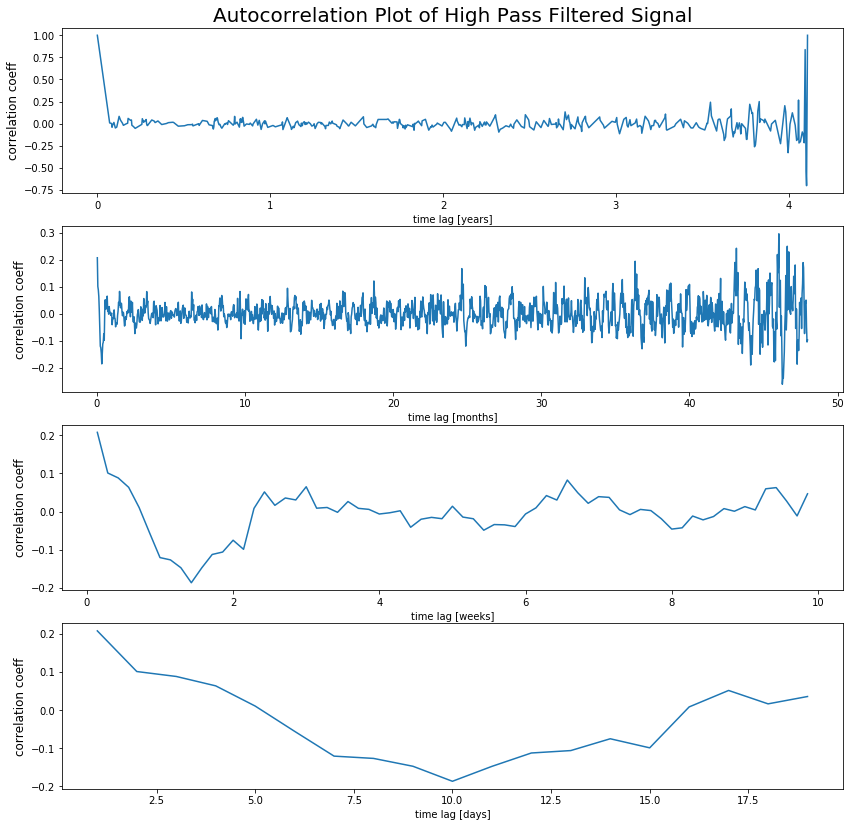

In [11]:
highPass = aqua.copy()
highPass.chl_oc3 = highPassChl
highPass.time = highPass.time - highPass.time.iloc[0]
timeLags = highPass.time.dt.days

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,14))

autoCorr = [highPassChl.autocorr(lag=dt) for dt in timeLags]
ax[0].plot(1/365*timeLags, autoCorr); 
ax[0].set_xlabel('time lag [years]'); ax[0].set_ylabel('correlation coeff', fontsize=12);

timeLags = np.arange(1,48*30) # 48 months
autoCorr = [highPassChl.autocorr(lag=dt) for dt in timeLags]
ax[1].plot(1/30*timeLags, autoCorr); 
ax[1].set_xlabel('time lag [months]'); ax[1].set_ylabel('correlation coeff', fontsize=12);

timeLags = np.arange(1,10*7) # 10 weeks
autoCorr = [highPassChl.autocorr(lag=dt) for dt in timeLags]
ax[2].plot(1/7*timeLags, autoCorr);
ax[2].set_xlabel('time lag [weeks]'); ax[2].set_ylabel('correlation coeff', fontsize=12);

timeLags = np.arange(1,20) # 20 days
autoCorr = [highPassChl.autocorr(lag=dt) for dt in timeLags]
ax[3].plot(timeLags, autoCorr);
ax[3].set_xlabel('time lag [days]'); ax[3].set_ylabel('correlation coeff', fontsize=12);

ax[0].set_title('Autocorrelation Plot of High Pass Filtered Signal', fontsize=20);

In [12]:
# !pip install nfft
#This is code developed by MIT for non uniform fourier transform, when time spacing is irregular
#https://github.com/jakevdp/nfft

70         0
72         2
73         3
76         6
80        10
        ... 
5375    5305
5376    5306
5377    5307
5379    5309
5382    5312
Name: time, Length: 1502, dtype: int64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


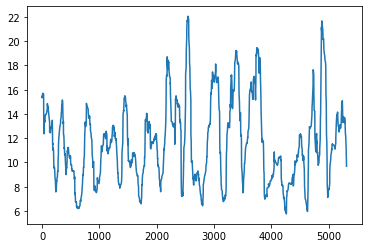

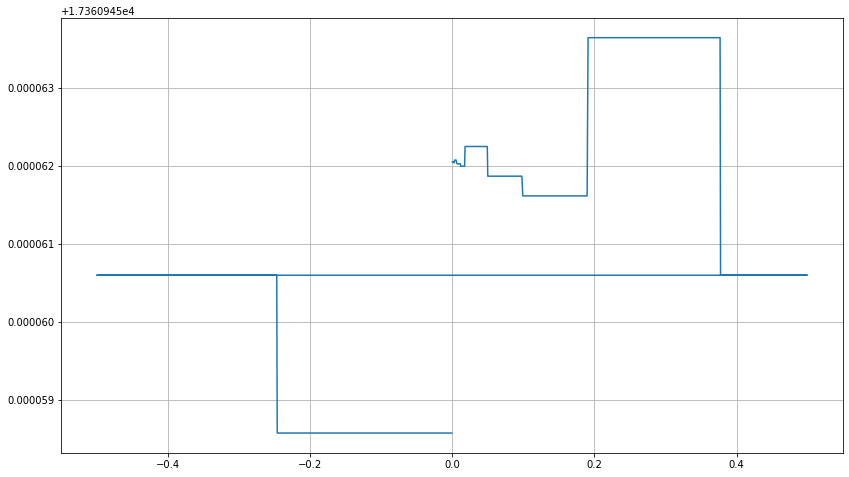

In [13]:
lowPass = aqua.copy()
lowPass.chl_oc3 = lowPassChl.copy()
lowPass = lowPass.dropna(how='any')  # this code wont run with nan values!

import numpy as np
from scipy.fftpack import rfft, irfft, fftfreq
from nfft import nfft

time   = lowPass.time - lowPass.time.iloc[0] #.dt.days # 1502 values totalling 5312 days
time   = time.dt.days
signal = lowPass.chl_oc3 # 1502  values
plt.figure(0)
plt.plot(time,signal)

print(time)

W_l = fftfreq(signal.size) # 1502 values
# f_signal_l = rfft(signal) # 1502 values

# nfft(x, f_k) where x is evaluation point (x-axis location) and f_k is the Fourier coefficient
f_signal_l = nfft(time, signal)

fig1 = plt.figure(1, figsize=(14,8)) #figsize=(14,12)
ax1 = fig1.add_subplot(111)
ax1.plot(W_l,f_signal_l)
ax1.grid()
# ax1.legend('Low Pass Chl FFT')
# # ax1.set_xlim(-0.01, 0.05)
# # ax1.set_ylim(-100, 500)
# # ax1.set_xlim(-0.05, 0.5)

# cut_f_signal = f_signal.copy()
# cut_f_signal[(W<0.45)] = 0
# cut_signal = irfft(cut_f_signal)
# plt.figure(2)
# plt.plot(cut_signal)

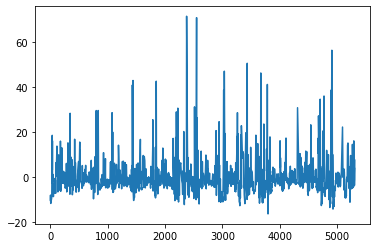

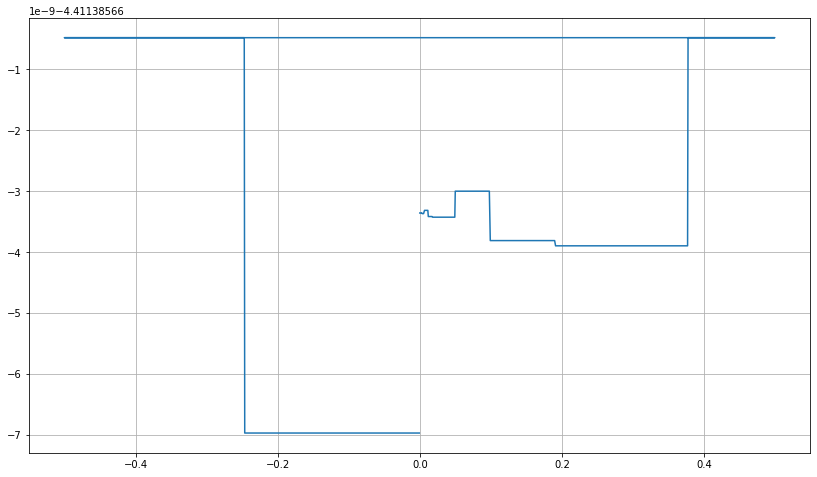

In [14]:
highPass = aqua.copy()
highPass.chl_oc3 = highPassChl.copy()
highPass = highPass.dropna(how='any')

time   = highPass.time - highPass.time.iloc[0] 
time   = time.dt.days
signal = highPass.chl_oc3 #
plt.figure(0)
plt.plot(time,signal)

W_h = fftfreq(signal.size) # 
# f_signal_h = rfft(signal) #
f_signal_h = nfft(time,signal)


fig1 = plt.figure(1, figsize=(14,8)) #figsize=(14,12)
ax1 = fig1.add_subplot(111)
ax1.plot(W_h,f_signal_h)
ax1.grid()
# ax1.set_xlim(-0.05, 0.15)

# cut_f_signal = f_signal.copy()
# cut_f_signal[(W<0.45)] = 0
# cut_signal = irfft(cut_f_signal)
# plt.figure(2)
# plt.plot(cut_signal)

These FFT charts don't appear to show meaningful data - the look inaccurate.

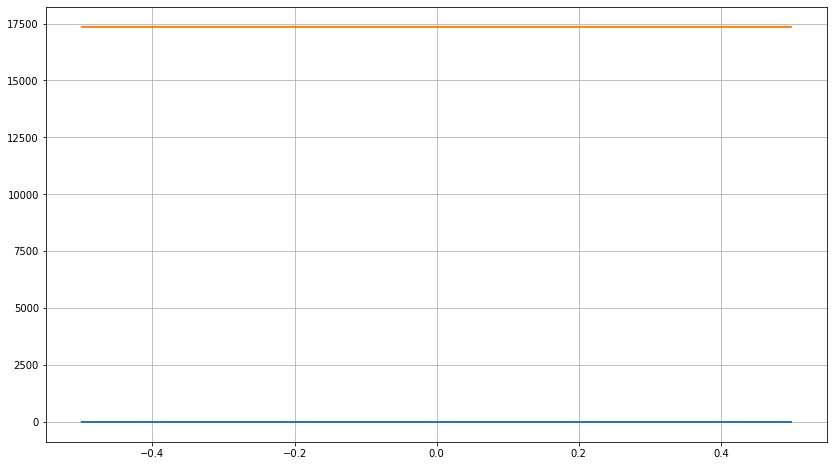

In [15]:
fig1 = plt.figure(1, figsize=(14,8)) #figsize=(14,12)
ax1 = fig1.add_subplot(111)
ax1.plot(W_h,f_signal_h)
ax1.plot(W_l,f_signal_l)
ax1.grid()
# ax1.set_xlim(-0.05, 0.15)

No appearent correlation between high pass and low pass FFT

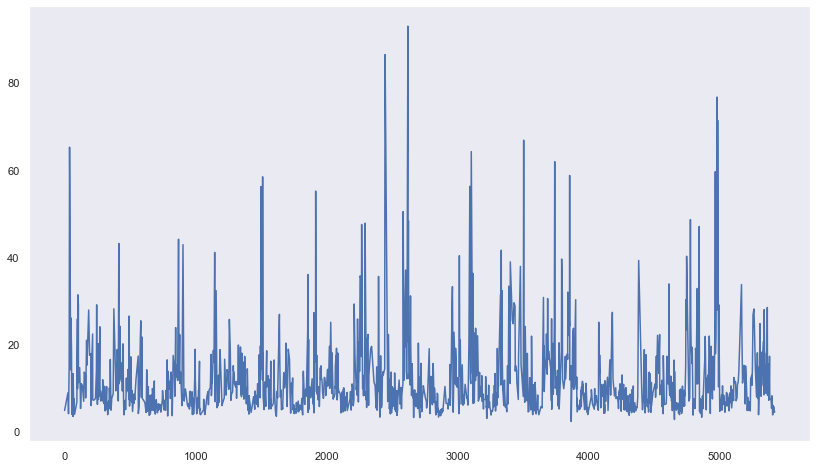

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

reg = aqua.copy()
reg = reg.dropna(how='any')

x = reg.time - reg.time.iloc[0]
x = x.dt.days
y = reg.chl_oc3
# plt.scatter(x, y, s=5)

fig1 = plt.figure(1, figsize=(14,8)) #figsize=(14,12)
ax1 = fig1.add_subplot(111)
ax1.plot(x, y)
ax1.grid()

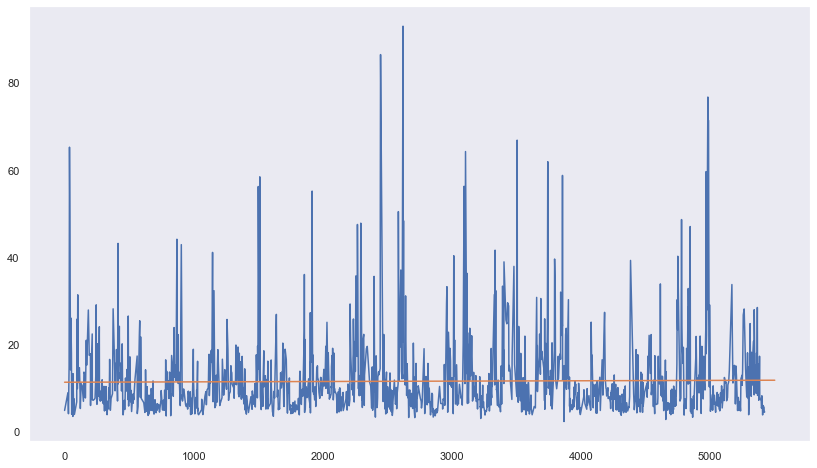

In [17]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 5500, 10)
yfit = model.predict(xfit[:, np.newaxis])

fig1 = plt.figure(1, figsize=(14,8)) #figsize=(14,12)
ax1 = fig1.add_subplot(111)
ax1.plot(x, y)
ax1.plot(xfit, yfit)
ax1.grid()

In [18]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     8.350759453689896e-05
Model intercept: 11.324936110113812


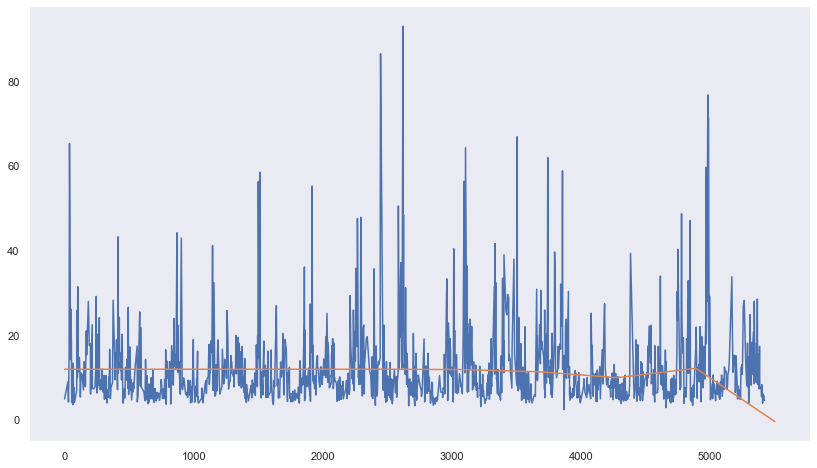

In [19]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(20),
                           LinearRegression())

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

fig1 = plt.figure(1, figsize=(14,8)) #figsize=(14,12)
ax1 = fig1.add_subplot(111)
ax1.plot(x, y)
ax1.plot(xfit, yfit)
ax1.grid()

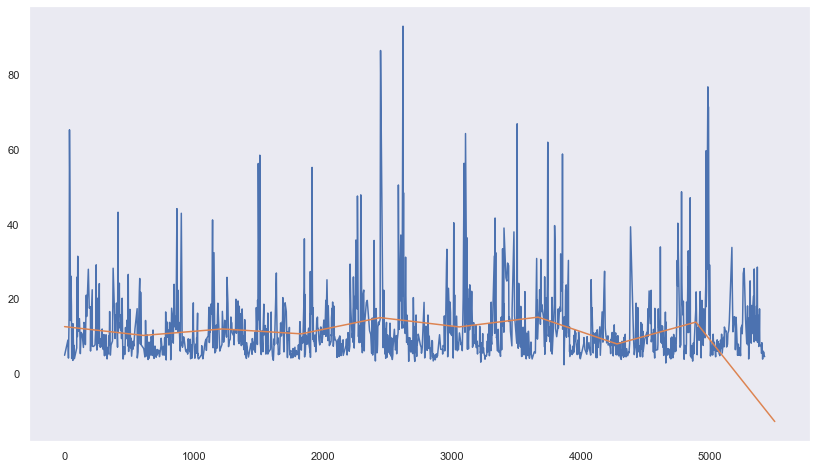

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

fig1 = plt.figure(1, figsize=(14,8)) #figsize=(14,12)
ax1 = fig1.add_subplot(111)
ax1.plot(x, y)
ax1.plot(xfit, yfit)
ax1.grid()
# plt.xlim(0, 3800)
# plt.ylim(0, 40)

I can't add enough features to the gaussian to get a meaningful fit

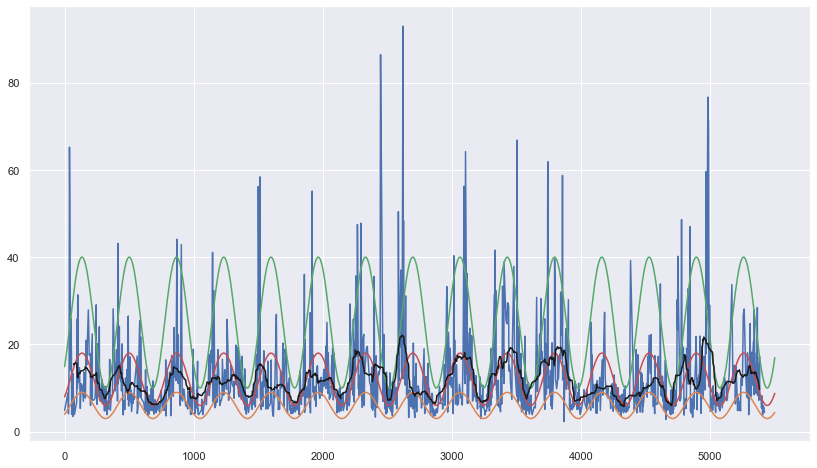

In [22]:
# Manual fit of yearly sinusoidal curve
xfit0 = np.linspace(0,5500,1531)
yfit0 = -np.sin(np.pi*(xfit0+140)/183)*3 + 6

xfit1 = np.linspace(0,5500,1531)
yfit1 = -np.sin(np.pi*(xfit1+140)/183)*15 + 25

xfit2 = np.linspace(0,5500,1531)
yfit2 = -np.sin(np.pi*(xfit2+140)/183)*6 + 12

xfit3 = np.linspace(0,5500,1531)
yfit3 = -np.sin(np.pi*(xfit2+120)/183)*36 + 40

fig1 = plt.figure(1, figsize=(14,8)) #figsize=(14,12)
ax1 = fig1.add_subplot(111)
ax1.plot(x, y)
ax1.plot(xfit0, yfit0)
ax1.plot(xfit1, yfit1)
ax1.plot(xfit2, yfit2)
ax1.plot(x, lowPassChl, c='k')
# ax1.plot(xfit3, yfit3)


None of the regression models work particularly well. They capture the changes over 6 months but fail to capture immediate changes on a monthly or weekly basis. A manual fit of a yearly sinusoidal curve seems to provide some indication of the variation.

In [23]:
weather = pd.read_csv('./CapeMayWeather.csv',parse_dates=['DATE']) #, index_col='DATE'
weather = weather.drop('STATION', axis=1)
weather = weather.drop('NAME', axis=1)
weather = weather.drop('WT01', axis=1)
weather = weather.drop('WT03', axis=1)
weather = weather.drop('WT04', axis=1)
weather = weather.drop('WT05', axis=1)
weather = weather.drop('WT06', axis=1)
weather = weather.drop('WT11', axis=1)
weather = weather.drop('SNOW', axis=1)
weather = weather.drop('SNWD', axis=1)
weather = weather.drop('TOBS', axis=1)
weather.head(10)

,DATE,PRCP,TMAX,TMIN
0,2005-01-01,0.00,65.0,38.0
1,2005-01-02,0.00,50.0,38.0
2,2005-01-03,0.00,61.0,37.0
3,2005-01-04,0.00,62.0,44.0
4,2005-01-05,0.12,46.0,40.0
5,2005-01-06,0.02,51.0,43.0
6,2005-01-07,0.00,46.0,38.0
7,2005-01-08,0.92,50.0,39.0
8,2005-01-09,0.00,42.0,33.0
9,2005-01-10,0.00,50.0,35.0


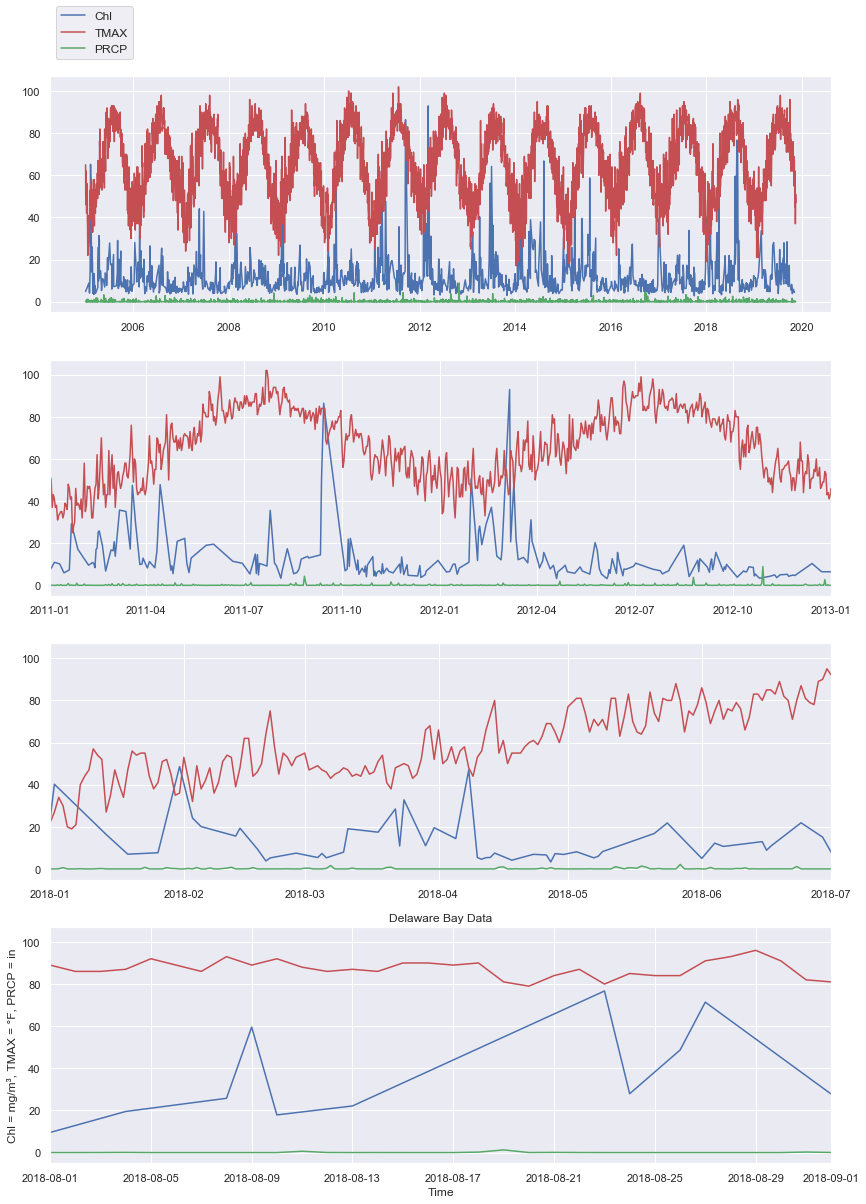

In [24]:
fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,20))

ax[0].plot(aqua['time'], aqua['chl_oc3'], label='Chl') 
ax[0].plot(weather['DATE'], weather['TMAX'], label='TMAX', c='r')
ax[0].plot(weather['DATE'], weather['PRCP'], label='PRCP', c='g')

ax[1].plot(aqua['time'], aqua['chl_oc3'], label='Chl') 
ax[1].plot(weather['DATE'], weather['TMAX'], label='TMAX', c='r')
ax[1].plot(weather['DATE'], weather['PRCP'], label='PRCP', c='g')
ax[1].set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2013-01-01'))

ax[2].plot(aqua['time'], aqua['chl_oc3'], label='Chl') 
ax[2].plot(weather['DATE'], weather['TMAX'], label='TMAX', c='r')
ax[2].plot(weather['DATE'], weather['PRCP'], label='PRCP', c='g')
ax[2].set_xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2018-07-01'))

ax[3].plot(aqua['time'], aqua['chl_oc3'], label='Chl') 
ax[3].plot(weather['DATE'], weather['TMAX'], label='TMAX', c='r')
ax[3].plot(weather['DATE'], weather['PRCP'], label='PRCP', c='g')
ax[3].set_xlim(pd.Timestamp('2018-08-01'), pd.Timestamp('2018-09-01'))

# fig1 = plt.figure(figsize=(20, 10))
# ax1 = fig1.add_subplot(111)

plt.xlabel('Time')
plt.ylabel('Chl = mg/m³, TMAX = °F, PRCP = in')
plt.title('Delaware Bay Data')
ax[0].legend(fontsize=12,loc='upper left',bbox_to_anchor=(0.00,1.32))
ax1.grid()

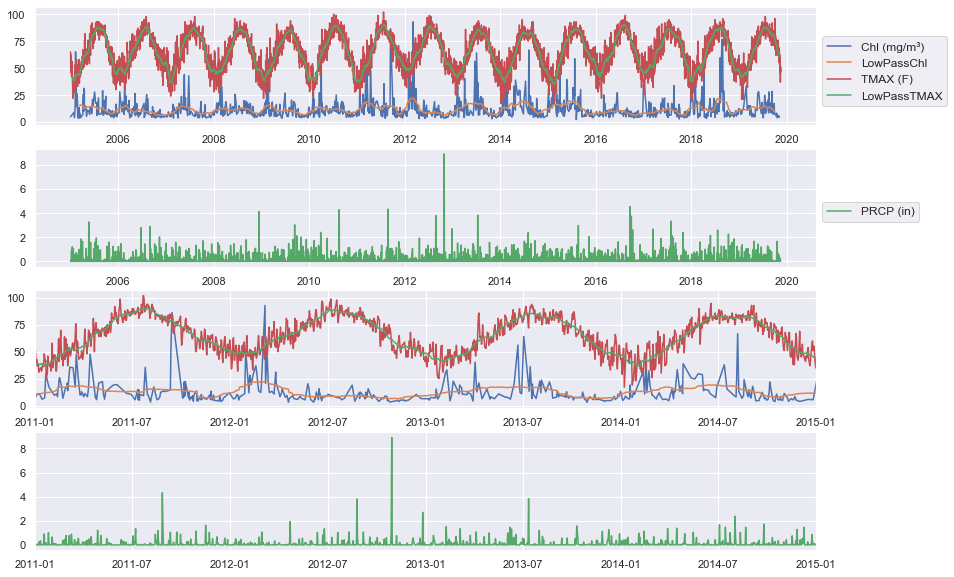

In [25]:
origSignalTMAX = weather.TMAX

windowSize = 30 #30 day window seems appropriate given the time scale of the data (years)

lowPassTMAX = origSignalTMAX.rolling(windowSize, center=True).mean()

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,10))

ax[0].plot(aqua['time'], aqua['chl_oc3'], label='Chl (mg/m³)') 
ax[0].plot(aqua['time'], lowPassChl, label='LowPassChl')
ax[0].plot(weather['DATE'], weather['TMAX'], label='TMAX (F)', c='r')
ax[0].plot(weather['DATE'], lowPassTMAX, label='LowPassTMAX')
ax[1].plot(weather['DATE'], weather['PRCP'], label='PRCP (in)', c='g')

ax[2].plot(aqua['time'], aqua['chl_oc3'], label='Chl') 
ax[2].plot(aqua['time'], lowPassChl, label='LowPassChl')
ax[2].plot(weather['DATE'], weather['TMAX'], label='TMAX', c='r')
ax[2].plot(weather['DATE'], lowPassTMAX, label='LowPassTMAX')
ax[3].plot(weather['DATE'], weather['PRCP'], label='PRCP', c='g')
ax[2].set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2015-01-01'))
ax[3].set_xlim(pd.Timestamp('2011-01-01'), pd.Timestamp('2015-01-01'))
# ax[0].legend()

ax[0].legend(fontsize=12,loc='upper left',bbox_to_anchor=(1.00,0.8))
ax[1].legend(fontsize=12,loc='upper left',bbox_to_anchor=(1.00,0.6))

  dChl_a/dt = alpha * Temp(t) + beta * Precip(t)

  Chl_a^(n+1) = Chl_a^n + delta_t * (alpha * Temp(t) + beta * Precip(t))

In [26]:
weather.DATE[0]

Timestamp('2005-01-01 00:00:00')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


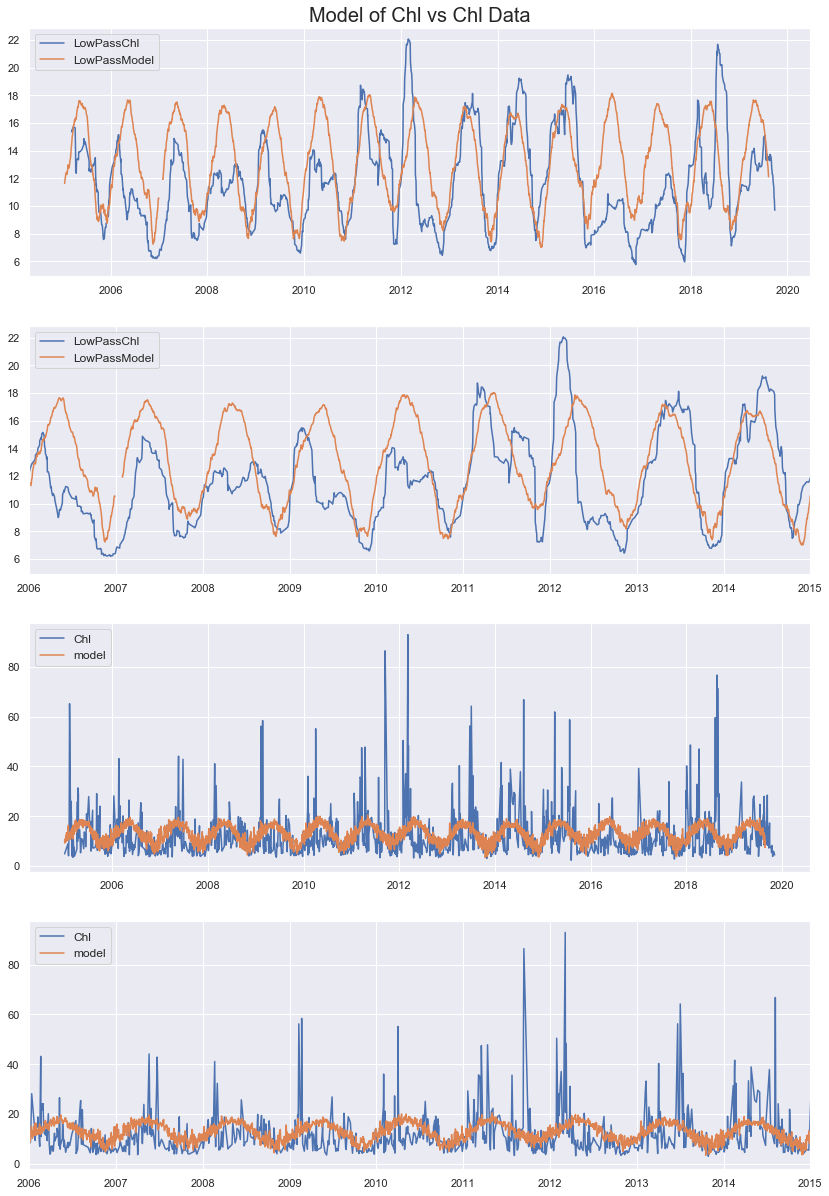

In [27]:
modelTime = np.linspace(0,5431,5431)
modelTime = modelTime.round(decimals=0)
modelTime = modelTime.astype(int)
modelChl = [0]
lag = 80
modelChl = modelChl + 1/5 * weather.TMAX[modelTime+lag] + 1/5 * weather.PRCP[modelTime+lag]

origSignalTMAX = weather.TMAX

windowSize = 30 # day window seems appropriate given the time scale of the data (years)

lowPassModel = modelChl.rolling(windowSize, center=True).mean()

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(14,21))

ax[0].plot(aqua['time'], lowPassChl, label='LowPassChl')
# ax[0].plot(aqua['time'], aqua['chl_oc3'], label='Chl')
# ax[0].plot(weather.DATE, modelChl, label='model')
ax[0].plot(weather.DATE, lowPassModel, label='LowPassModel')

ax[1].plot(aqua['time'], lowPassChl, label='LowPassChl') 
# ax[1].plot(weather.DATE, modelChl, label='model')
ax[1].plot(weather.DATE, lowPassModel, label='LowPassModel')
ax[1].set_xlim(pd.Timestamp('2006-01-01'), pd.Timestamp('2015-01-01'))

ax[0].legend(fontsize=12,loc='upper left',bbox_to_anchor=(0.00,1.))
ax[1].legend(fontsize=12,loc='upper left',bbox_to_anchor=(0.00,1.))

ax[2].plot(aqua['time'], aqua['chl_oc3'], label='Chl') 
ax[2].plot(weather.DATE, modelChl, label='model')

ax[3].plot(aqua['time'], aqua['chl_oc3'], label='Chl') 
ax[3].plot(weather.DATE, modelChl, label='model')
ax[3].set_xlim(pd.Timestamp('2006-01-01'), pd.Timestamp('2015-01-01'))

ax[2].legend(fontsize=12,loc='upper left',bbox_to_anchor=(0.00,1.))
ax[3].legend(fontsize=12,loc='upper left',bbox_to_anchor=(0.00,1.))

ax[0].set_title('Model of Chl vs Chl Data', fontsize=20);

The low pass signal of the model appears to roughly reflect the pattern of chlorophyll. However, the raw signal of the model fails to capture the complxity of the chl data. This model shows that tmeperature and chl can be roughly correlated. Causation is likely much more complex.